# BBC News Classification

DTSA 5510 Unsupervised Algorithms in Machine Learning

University of Colorado Boulder

## Import Modules

In [26]:
# data manipulation
import pandas as pd
import numpy as np

# visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# natural language tool kit
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

# sci-kit learn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD  
from sklearn.feature_selection import chi2
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# regex
import re

# storage
from scipy.sparse import save_npz
import pickle

# warnings
import warnings


In [3]:
warnings.filterwarnings('ignore', message="The parameter 'token_pattern' will not be used")
warnings.filterwarnings('ignore', category=RuntimeWarning, module='pandas.io.formats.format')

## Load Data

In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
train_data = pd.read_csv('/kaggle/input/learn-ai-bbc/BBC News Train.csv')
test_data = pd.read_csv('/kaggle/input/learn-ai-bbc/BBC News Test.csv')

# Unsupervised Approach - Truncated SVD

## Exploratory Data Analysis


Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB

Testing Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  735 non-null    int64 
 1   Text       735 non-null    object
dtypes: int64(1), object(1)
memory usage: 11.6+ KB

Train Data Shape: (1490, 3)

Test Data Shape: (735, 2)

Training Data Head:
   ArticleId                                               Text  Category
0       1833  worldcom ex-boss launches defence lawyers defe...  business
1        154  german business confidence slides german busin...  busine

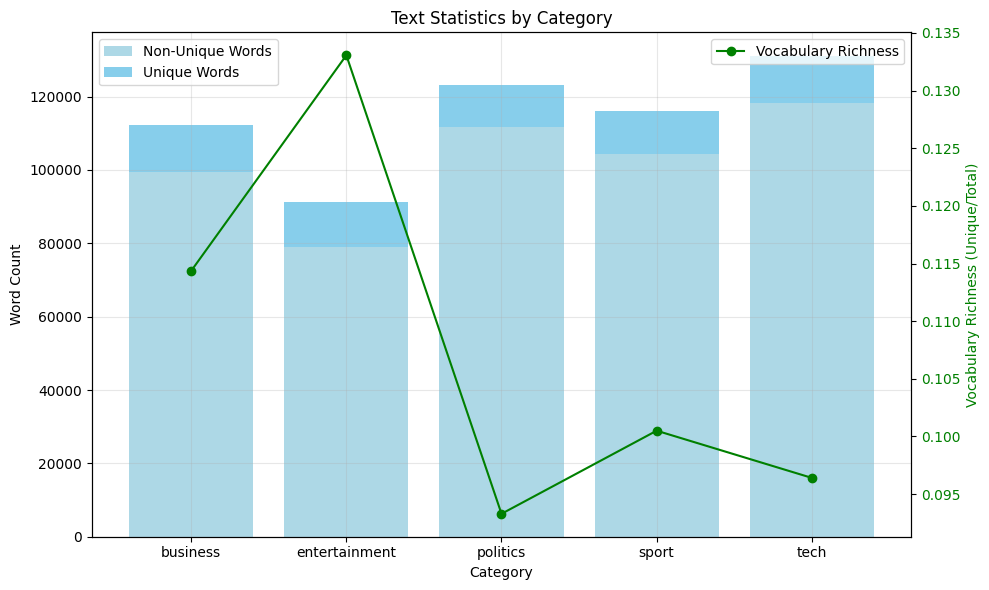

In [6]:
print('\nTraining Data Info:')
train_data.info()

print('\nTesting Data Info:')
test_data.info()

print('\nTrain Data Shape:', train_data.shape)
print('\nTest Data Shape:', test_data.shape)

print('\nTraining Data Head:')
print(train_data.head())

print("\nMissing values in Training Set:")
print(train_data.isnull().sum())
print("\nMissing Values in Test Set:")
print(test_data.isnull().sum())

print("\nDuplicated values in Training Set:")
print(train_data.duplicated().sum())
print("\nDuplicated Values in Test Set:")
print(test_data.duplicated().sum())

print("\nCategory Counts in Train Set:")
category_counts = train_data['Category'].value_counts()
print(category_counts)

texts_by_category = train_data.groupby('Category')['Text'].apply(list)
category_stats = {}
for category, texts in texts_by_category.items():
    combined_text = ' '.join(texts)
    all_words = combined_text.lower().split()
    total_words = len(all_words)
    unique_words = len(set(all_words))
    category_stats[category] = {
        'total_words': total_words,
        'unique_words': unique_words,
        'vocabulary_richness': unique_words / total_words
    }

stats_df = pd.DataFrame.from_dict(category_stats, orient='index')
print("\nText Statistics by Category:")
print(stats_df)

fig, ax1 = plt.subplots(figsize=(10, 6))
stats_df['non_unique_words'] = stats_df['total_words'] - stats_df['unique_words']
ax1.bar(stats_df.index, stats_df['non_unique_words'], label='Non-Unique Words', color='lightblue')
ax1.bar(stats_df.index, stats_df['unique_words'], bottom=stats_df['non_unique_words'], label='Unique Words', color='skyblue')
ax1.set_xlabel('Category')
ax1.set_ylabel('Word Count')
ax1.set_title('Text Statistics by Category')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

ax2 = ax1.twinx()
ax2.plot(stats_df.index, stats_df['vocabulary_richness'], color='green', marker='o', label='Vocabulary Richness')
ax2.set_ylabel('Vocabulary Richness (Unique/Total)', color='green')
ax2.tick_params(axis='y', labelcolor='green')
ax2.legend(loc='upper right')
plt.tight_layout()
plt.show()

## Data Preprocessing

In [7]:
def process_stop_words(stopwords_list):
    
    stop_words_set = set()
    for word in stopwords_list:
        
        processed_word = word.lower()
        processed_word = re.sub(r'[^\w\s]', '', processed_word)
        processed_word = re.sub(r'\d+', '', processed_word)
        
        if processed_word:
            
            stemmed_word = stemmer.stem(processed_word)
            stop_words_set.add(stemmed_word)
    
    return list(stop_words_set)

def custom_tokenizer(text):
    
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    words = text.split()
    stems = [stemmer.stem(word) for word in words]
    
    return stems

def predict_labels_training(similarity_matrix, labels, exclude_self=True):

    predictions = []
    for i, sim in enumerate(similarity_matrix):

        sim[i] = -float('inf')  # Exclude self-similarity
        most_similar_idx = np.argmax(sim)
        predictions.append(labels[most_similar_idx])
    
    return predictions

In [8]:
stemmer = SnowballStemmer('english')
stop_words = process_stop_words(stopwords.words('english'))
tfidf_vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer, stop_words=stop_words)
tfidf_matrix_train = tfidf_vectorizer.fit_transform(train_data['Text'])
tfidf_matrix_test = tfidf_vectorizer.transform(test_data['Text'])

print(f"\nTF-IDF Matrix Shape (Train): {tfidf_matrix_train.shape}")
print(f"TF-IDF Matrix Shape (Test): {tfidf_matrix_test.shape}")
print(f"Number of Features: {len(tfidf_vectorizer.get_feature_names_out())}")


TF-IDF Matrix Shape (Train): (1490, 17699)
TF-IDF Matrix Shape (Test): (735, 17699)
Number of Features: 17699


## Model Training & Hyperparameter Tuning

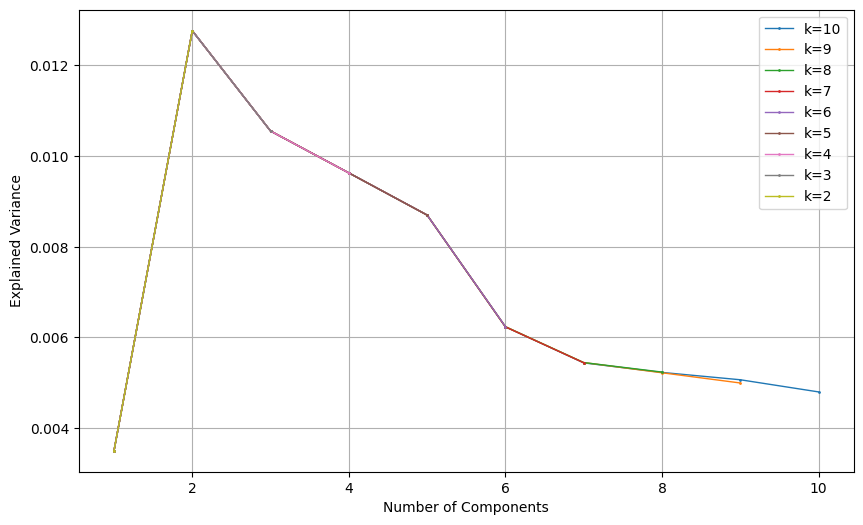

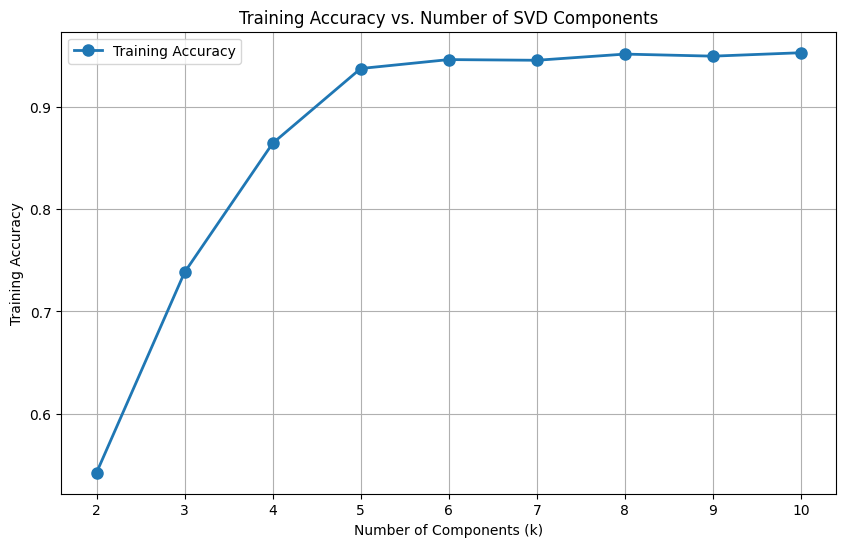

k | Training Accuracy
2  | 0.5423
3  | 0.7383
4  | 0.8644
5  | 0.9376
6  | 0.9463
7  | 0.9456
8  | 0.9517
9  | 0.9497
10 | 0.9530


In [9]:
train_labels = train_data['Category'].values
k_values = range(2, 11)
train_accuracies = []

plt.figure(figsize=(10,6))
for k in reversed(k_values):
    svd = TruncatedSVD(n_components=k)
    tfidf_SVD_train = svd.fit_transform(tfidf_matrix_train)

    train_similarity = cosine_similarity(tfidf_SVD_train, tfidf_SVD_train)
    train_predictions = predict_labels_training(train_similarity, train_labels)
    
    train_acc = accuracy_score(train_labels, train_predictions)
    train_accuracies.append(train_acc)

    cumulative_variance = svd.explained_variance_ratio_ 
    plt.plot(range(1, k + 1), cumulative_variance, 
             label=f'k={k}', marker='o', markersize=1, linewidth=1)

plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(list(k_values), list(reversed(train_accuracies)), label='Training Accuracy', marker='o', markersize=8, linewidth=2)
plt.xlabel('Number of Components (k)')
plt.ylabel('Training Accuracy')
plt.title('Training Accuracy vs. Number of SVD Components')
plt.grid(True)
plt.legend()
plt.show()

print("k | Training Accuracy")
for k, acc in zip(k_values, reversed(train_accuracies)):
    print(f"{k:<2} | {acc:.4f}")

In [10]:

max_features_values = [1000, 5000, 10000, None]  
max_df_values = [0.5, 0.75, 0.9]  
results = []

for f in max_features_values:
    
    for d in max_df_values:
        
        tfidf_vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer, stop_words=stop_words, max_df=d, max_features=f)
        tfidf_matrix_train = tfidf_vectorizer.fit_transform(train_data['Text'])

        svd = TruncatedSVD(n_components=5)
        tfidf_SVD_train = svd.fit_transform(tfidf_matrix_train)

        train_similarity = cosine_similarity(tfidf_SVD_train, tfidf_SVD_train)
        train_predictions = predict_labels_training(train_similarity, train_labels)
        
        train_acc = accuracy_score(train_labels, train_predictions)
        results.append({'max_features': f, 'max_df': d, 'train_accuracy': train_acc})

results_df = pd.DataFrame(results)
print("\nHyperparameter Tuning Results:")
print(results_df)


Hyperparameter Tuning Results:
    max_features  max_df  train_accuracy
0         1000.0    0.50        0.930201
1         1000.0    0.75        0.932215
2         1000.0    0.90        0.933557
3         5000.0    0.50        0.938926
4         5000.0    0.75        0.941611
5         5000.0    0.90        0.940268
6        10000.0    0.50        0.934899
7        10000.0    0.75        0.941611
8        10000.0    0.90        0.938926
9            NaN    0.50        0.936913
10           NaN    0.75        0.940268
11           NaN    0.90        0.941611


In [11]:
best_hyperparams = results_df[results_df['train_accuracy'] == results_df['train_accuracy'].max()]
print(best_hyperparams)

    max_features  max_df  train_accuracy
4         5000.0    0.75        0.941611
7        10000.0    0.75        0.941611
11           NaN    0.90        0.941611


## Final Model Build & Prediction

Unsupervised (k=5) Training Accuracy: 0.9416


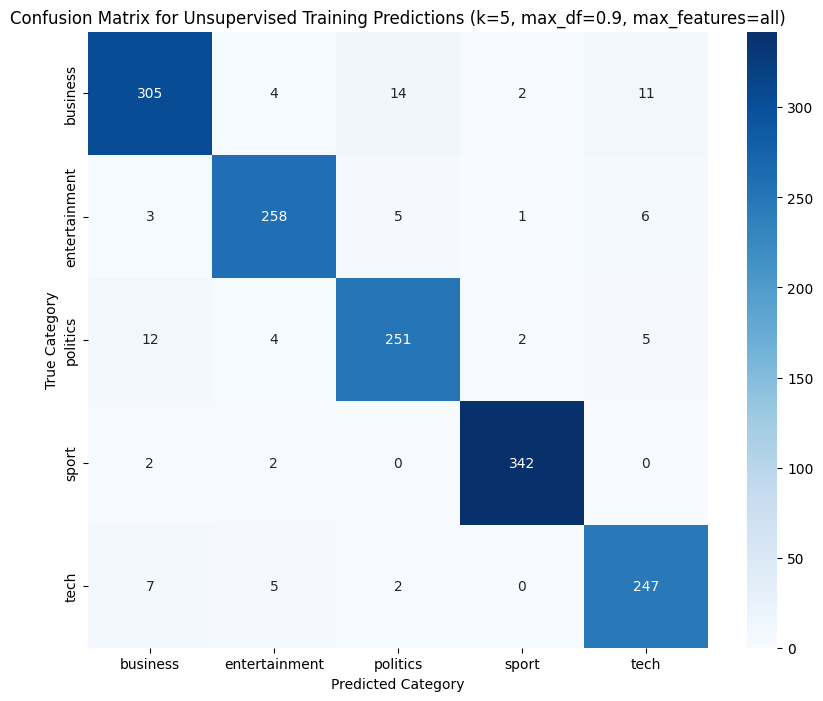


Unsupervised (k=5) Training Classification Report:
               precision    recall  f1-score   support

     business       0.93      0.91      0.92       336
entertainment       0.95      0.95      0.95       273
     politics       0.92      0.92      0.92       274
        sport       0.99      0.99      0.99       346
         tech       0.92      0.95      0.93       261

     accuracy                           0.94      1490
    macro avg       0.94      0.94      0.94      1490
 weighted avg       0.94      0.94      0.94      1490



In [14]:
# final hyperparameters
k_final = 5
max_features_final = None
max_df_final = 0.90

# preprocess data
tfidf_vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer, stop_words=stop_words, max_df=max_df_final, max_features=max_features_final)
tfidf_matrix_train = tfidf_vectorizer.fit_transform(train_data['Text'])
tfidf_matrix_test = tfidf_vectorizer.transform(test_data['Text'])

# train and fit truncated SVD
svd = TruncatedSVD(n_components=k_final)
tfidf_SVD_train = svd.fit_transform(tfidf_matrix_train)
tfidf_SVD_test = svd.transform(tfidf_matrix_test)

# train
train_similarity = cosine_similarity(tfidf_SVD_train, tfidf_SVD_train)
train_predictions = predict_labels_training(train_similarity, train_labels, exclude_self=True)

# create training set confusion matrix
cm = confusion_matrix(train_labels, train_predictions)
plt.figure(figsize=(10, 8))
categories = np.unique(train_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted Category')
plt.ylabel('True Category')
plt.title(f'Confusion Matrix for Unsupervised Training Predictions (k={k_final}, max_df={max_df_final}, max_features=all)')
plt.show()
print(f"\nUnsupervised (k={k_final}) Training Classification Report:")
print(classification_report(train_labels, train_predictions))

# predict on testing set and save for submission
test_similarity = cosine_similarity(tfidf_SVD_test, tfidf_SVD_train)
test_predictions = predict_labels_training(test_similarity, train_labels)
submission = pd.DataFrame({'ArticleId': test_data['ArticleId'], 'Category': test_predictions})
submission.to_csv('submission.csv', index=False)

# Supervised Approach - Random Forrest Classifier

## Data Preprocessing

In [17]:
rf_tfidf_vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer, stop_words=stop_words, max_df=max_df_final, max_features=max_features_final)
rf_tfidf_matrix_train = rf_tfidf_vectorizer.fit_transform(train_data['Text'])

## Training Validation & Data Size Search

In [34]:
train_labels = train_data['Category']
train_sizes = [0.1, 0.2, 0.5]
train_size_results = []

for size in train_sizes:
    
    X_train, X_val, y_train, y_val = train_test_split(rf_tfidf_matrix_train, train_labels, train_size=size, random_state=19)

    rf = RandomForestClassifier()
    rf.fit(X_train, y_train)
    train_preds = rf.predict(X_train)
    train_acc = accuracy_score(y_train, train_preds)
    
    val_preds = rf.predict(X_val)
    val_acc = accuracy_score(y_val, val_preds)
    
    train_size_results.append({'train_size': f"{int(size * 100)}%", 'train_accuracy': train_acc, 'val_accuracy': val_acc})
    #print(f"Train size: {int(size * 100)}%, Training Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}")

train_size_results_df = pd.DataFrame(train_size_results)
print("\nRandomForest Data Size Tuning Results:")
print(train_size_results_df)


RandomForest Data Size Tuning Results:
  train_size  train_accuracy  val_accuracy
0        10%             1.0      0.850112
1        20%             1.0      0.901846
2        50%             1.0      0.940940


Text(0.5, 1.0, 'Confusion Matrix for Random Forest Validation (Holdout) Predictions')

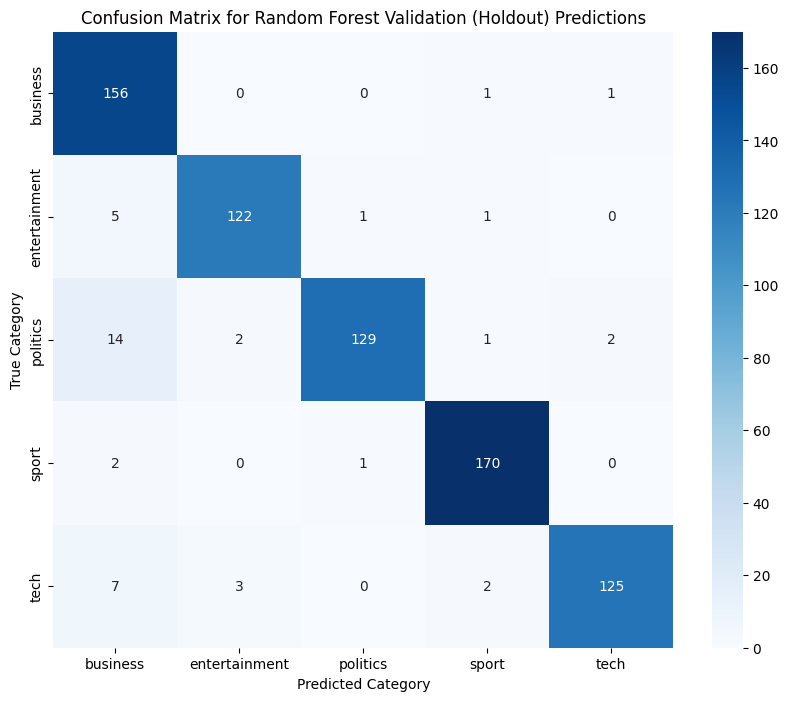

In [55]:
X_train, X_val, y_train, y_val = train_test_split(rf_tfidf_matrix_train, train_labels, train_size=0.5, random_state=19)

rf = RandomForestClassifier()
rf.fit(X_train, y_train)


train_preds = rf.predict(X_train)
train_acc = accuracy_score(y_train, train_preds)

val_preds = rf.predict(X_val)
val_acc = accuracy_score(y_val, val_preds)

cm_val = confusion_matrix(y_val, val_preds)
categories = np.unique(train_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', 
            xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted Category')
plt.ylabel('True Category')
plt.title('Confusion Matrix for Random Forest Validation (Holdout) Predictions')

## Predict on Testing Set

In [46]:
print(rf_tfidf_matrix_test.shape)

(735, 12991)


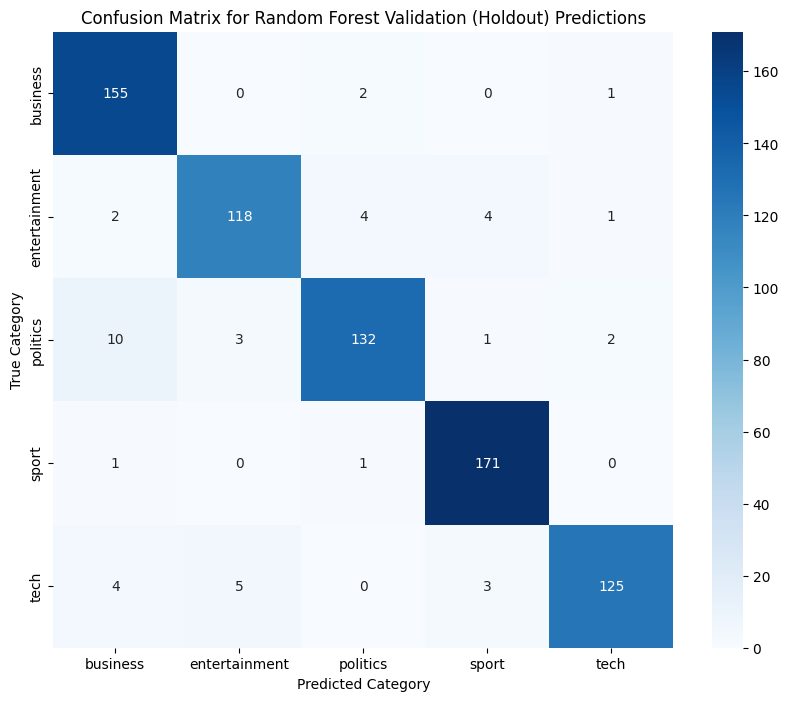

   ArticleId  Category
0       1018     sport
1       1319      tech
2       1138     sport
3        459  business
4       1020     sport


In [52]:
# random forest
rf = RandomForestClassifier()

# train
rf_tfidf_vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer, stop_words=stop_words, max_df=max_df_final, max_features=max_features_final)
rf_tfidf_matrix_train = rf_tfidf_vectorizer.fit_transform(train_data['Text'])
rf.fit(rf_tfidf_matrix_train, train_labels)

# predict
rf_tfidf_matrix_test = rf_tfidf_vectorizer.transform(test_data['Text'])
test_preds = rf.predict(rf_tfidf_matrix_test)


submission = pd.DataFrame({'ArticleId': test_data['ArticleId'], 'Category': test_preds})
submission.to_csv('submission.csv', index=False)
print(submission.head())  